# Data Cleaning

In this part we conduct data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
dataset_path = "../dataset/"
data = pd.read_csv(dataset_path + "data_joined.csv")
data=data.drop('Filming_Location',axis=1)
a = data.dropna(axis=0)
a.reset_index(drop=True,inplace=True)
a.head(1)

,Movie_Title,Movie_ID,Budget,Cast,Crew,Studios,Genre,Keywords,Languages,Countries,Release_Data,Runtime,Gross_worldwide,Rating,Rating_Count,ListOfCertificate
0,Star Wars: Episode VII - The Force Awakens,2488496,"$245,000,000","Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...","Lawrence Kasdan,Michael Arndt,J.J. Abrams","Lucasfilm,Bad Robot,Truenorth Productions","Action,Adventure,Sci-Fi","reboot,sanitation employee,remake,crash landin...",English,United States,2015-12-18,2 hours 18 minutes,"$2,069,521,700",7.8,893K,PG-13


## Currency attribute

**Input**: Input dataframe with unprocessed currency

**Output**: Processed one

Currency type in Budget and Gross_Woldwide

In [3]:
currency=[str(s)[0] for s in a['Budget'].unique()]
print(set(currency))
currency=[str(s)[0] for s in a['Gross_worldwide'].unique()]
print(set(currency))

{'€', '$'}
{'$'}


Function use to parse money

In [4]:
def parseMoney(beforeParsed):
    #Loại bỏ ký tự '$','€' và ',' trong xâu rồi chuyển về dạng integer
    if '$' in beforeParsed:
      afterParsed=int(beforeParsed.strip('$').replace(',',""))
    else:
      afterParsed=int(int(beforeParsed.strip('€').replace(',',""))*1.14)
    return afterParsed

Convert currency

In [5]:
a['Budget']=a['Budget'].apply(parseMoney)
a['Gross_worldwide']=a['Gross_worldwide'].apply(parseMoney)

In [6]:
a.head(1)

,Movie_Title,Movie_ID,Budget,Cast,Crew,Studios,Genre,Keywords,Languages,Countries,Release_Data,Runtime,Gross_worldwide,Rating,Rating_Count,ListOfCertificate
0,Star Wars: Episode VII - The Force Awakens,2488496,245000000,"Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...","Lawrence Kasdan,Michael Arndt,J.J. Abrams","Lucasfilm,Bad Robot,Truenorth Productions","Action,Adventure,Sci-Fi","reboot,sanitation employee,remake,crash landin...",English,United States,2015-12-18,2 hours 18 minutes,2069521700,7.8,893K,PG-13


## Multivalued attributes

Multivalued attributes is seperated by comma (,)

- The fields Cast, Genre, Studios, ListOfCertificate, Keywords, Languages, Countries are multivalued so we change to **List** Data Structure

In [7]:
def convertToList(fieldValue):
  arrayValue=fieldValue.split(',')
  return arrayValue

In [8]:
# Cast, Genre, Studios, ListOfCertificate
cols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries','Crew']
for col in cols:
  a[col]=a[col].apply(convertToList)

Note!
After change to list we will need this function this to load again in another part

In [9]:
"""

import ast
cols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries']
for col in cols:
    a[col]=a[col].apply(ast.literal_eval)
    
"""

"\n\nimport ast\ncols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries']\nfor col in cols:\n    a[col]=a[col].apply(ast.literal_eval)\n    \n"

- The fields ListOfCertificate are multivalued and also need to clean

In [10]:
def getUniqueCer(dataframe):   
    lCer=set()
    for i in dataframe['ListOfCertificate']:
        for y in i:
            lCer.add(y)
    return lCer

In [11]:
getUniqueCer(a)

{'G', 'GP', 'M', 'M/PG', 'NC-17', 'PG', 'PG-13', 'R', 'X'}

Those certificate is out of date. Can be replace:

- M, GP and M/PG are listed to PG

- X replaced by NC-17

In [12]:
def convertCertificate(certificates):
    newCertificate=set()
    type1=['M','GP','M/PG']
    type2=['X']
    for i in certificates:
        if i in type1:
            newCertificate.add('PG')
        elif i in type2:
            newCertificate.add('NC-17')
        else:
            newCertificate.add(i)
    return list(newCertificate)

In [13]:
a['ListOfCertificate']=a['ListOfCertificate'].apply(convertCertificate)
getUniqueCer(a)

{'G', 'NC-17', 'PG', 'PG-13', 'R'}

## Process multivalued fields with Money and Count
1. Input
- Dataframe: Dataframe need to be process
- Name: Name of the columns we want to process. In this project they are **Cast**, **Genre** or **Studios**

2. Output
- Output: DataFrame contains information related to the columns combined with Money and Count

In [14]:
def parseWithMoneyAndCount(dataframe, colName):
    result = []
    count = []
    gross = []
    for i,record in enumerate(dataframe[colName]):
      for x in record:
        #Lưu kết quả vào mảng tương ứng
          result.append(x)
          gross.append(dataframe['Gross_worldwide'][i])
          count.append(1)
    #Tạo dataFrame
    t = pd.DataFrame({colName:result, 'Money':gross, 'Count':count})
    #Loại bỏ các giá trị trùng nhau và cộng các hàng tương ứng lại 
    result = t.groupby(colName).sum()
    #Sắp xếp lại dataFrame
    sort_by_money = result.sort_values('Money', ascending = False)
    return sort_by_money

## Xử lý dữ liệu với cột Cast, Genre, Studios, ListOfCertificate

- Tách lấy thông tin cần thiết

- Tính tổng số doanh thu của những bộ phim mà họ từng tham gia

In [15]:
# phần Money trong hàm này cần được chuẩn hóa bằng hàm xử lý tiền tệ trước khi truyền vào
cast = parseWithMoneyAndCount(a,'Cast')
cast

,Money,Count
Cast,,
Samuel L. Jackson,18456068690,72
Robert Downey Jr.,15039939731,46
Scarlett Johansson,14258148970,40
Zoe Saldana,12244178786,26
Dwayne Johnson,11942043248,33
...,...,...
Thomas Carrigan,746,1
Celia Lovsky,210,1
Belle Mitchell,210,1


Tương tự với cột Genre, Studios và ListOfCertificate

In [16]:
genre = parseWithMoneyAndCount(a,'Genre')
genre

,Money,Count
Genre,,
Adventure,287126772253,1260
Action,257211396402,1551
Comedy,206984038964,2268
Drama,202661234532,3003
Thriller,159883807756,1819
Sci-Fi,149409917064,761
Fantasy,146296058095,820
Family,130284457945,725
Romance,98429498497,1397


In [17]:
studio = parseWithMoneyAndCount(a,'Studios')
studio

,Money,Count
Studios,,
Walt Disney Pictures,67988077450,186
Warner Bros.,62251946993,380
Universal Pictures,60582426477,409
Paramount Pictures,52117636071,355
Columbia Pictures,50418451892,355
...,...,...
Commonwealth Film Manufacturing,4550,1
New Coast Productions,4550,1
Elmer Enterprises,4534,1


In [18]:
certificate = parseWithMoneyAndCount(a,'ListOfCertificate')
certificate

,Money,Count
ListOfCertificate,,
PG-13,266649426461,1810
R,145322456967,2585
PG,134940788389,1100
G,25311167254,185
NC-17,755519496,19


## Xử lý dữ liệu cột Keywords, Languages, Countries
Dữ liệu dạng này chủ yếu chỉ cần tách và xem xét đến độ phổ biến nên chỉ cần đếm số lượng

In [19]:
def parseWithCount(dataframe, name):
    result = []
    count = []
    for record in dataframe[name]:
      for x in record:
        result.append(x)
        count.append(1)
    result = pd.DataFrame({name:result, 'Count':count})
    #Loại bỏ trùng lặp 
    result = result.groupby(name).sum()
    sort_by_count = result.sort_values('Count', ascending=False)
    return sort_by_count

### Cột keywords

In [20]:
keywords = parseWithCount(a,'Keywords')
keywords

,Count
Keywords,
female nudity,115
new york city,110
female protagonist,107
murder,104
sex scene,99
...,...
hebrew,1
heavyweight champion,1
heavy water,1


### Cột Languages

In [21]:
languages = parseWithCount(a, 'Languages')
languages

,Count
Languages,
English,5469
Spanish,674
French,585
German,322
Italian,280
...,...
Cheyenne,1
Chechen,1
Saami,1


### Cột Countries

In [22]:
countries = parseWithCount(a, 'Countries')
countries

,Count
Countries,
United States,5158
United Kingdom,960
Canada,515
France,448
Germany,413
...,...
Jamaica,1
Kazakhstan,1
Lithuania,1


## Chuẩn hóa lại dữ liệu dạng thời gian
### 1. Dữ liệu cột runtime dạng giờ-phút
Hàm chuyển thời gian về dạng phút

In [23]:
def convertTime(time):
    time = str(time)
    # Loại bỏ khoảng trắng
    time = time.replace(" ", "")
    # nếu trong chuỗi có chứa 'hour' -> có 2 khả năng là chuỗi có chứa 'hours' hoặc 'hour' 
    if "hour" in time:
        hours = 0
        # Nếu chuỗi chứa 'hours', loại bỏ 'hours' và lấy ký tự đầu tiên nhân với 60
        if "hours" in time:
            hours = int(time[0])*60
            after_eliminate_hour = time.replace("hours", "")
        else:
        # Nếu không thì nghĩa là ký tự đầu tiên bằng 1 => 60 phút
            hours = 60
            after_eliminate_hour = time.replace("hour", "")
        minutes = 0
        # Sau đó lấy số phút đó cộng với số phút nếu có đằng sau 
        if "minute" in after_eliminate_hour:
            if "minutes" in after_eliminate_hour:
                minutes = int(after_eliminate_hour.replace("minutes","")[1:])
            else:
                minutes = 1
        return hours+minutes
    # Nếu chuỗi không chứa 'hour' -> chỉ cần loại bỏ chuỗi 'minutes' rồi chuyển về int là xong
    else:
      return int(time.replace("minutes",""))

Chuẩn hóa thời gian cho bộ dữ liệu

In [24]:
a['Runtime']=a['Runtime'].apply(convertTime)

### 2. Dữ liệu cột release_date dạng ngày tháng năm
Tách ngày, tháng, năm của từng bộ phim

In [25]:
a['Release_Data']=pd.to_datetime(a['Release_Data'], format='%Y-%m-%d')
a=a.assign(Release_Year=a['Release_Data'].dt.year)
a=a.assign(Release_Month=a['Release_Data'].dt.month)
a=a.assign(Release_Day=a['Release_Data'].dt.day)

## Xử lý dữ liệu cột Rating và Rating_Count
- Hàm chuẩn hóa lại dữ liệu cột Rating_Count và chuyển dữ liệu cột Rating về float

In [26]:
def convertRatingCount(rating_count):
  rate = str(rating_count)
  if 'M' in rate:
        return int(float(rate.replace("M", ""))*1000000)
  elif 'K' in rate:
        return int(float(rate.replace("K", ""))*1000)
  else:
        return int(rate)

In [27]:
# Đưa dữ liệu cột rating_count về integer
a['Rating_Count']=a['Rating_Count'].apply(convertRatingCount)
# Đưa dữ liệu cột rating về dạng float
a['Rating']=a['Rating'].astype(float)

In [28]:
a

,Movie_Title,Movie_ID,Budget,Cast,Crew,Studios,Genre,Keywords,Languages,Countries,Release_Data,Runtime,Gross_worldwide,Rating,Rating_Count,ListOfCertificate,Release_Year,Release_Month,Release_Day
0,Star Wars: Episode VII - The Force Awakens,2488496,245000000,"[Daisy Ridley, John Boyega, Oscar Isaac, Domhn...","[Lawrence Kasdan, Michael Arndt, J.J. Abrams]","[Lucasfilm, Bad Robot, Truenorth Productions]","[Action, Adventure, Sci-Fi]","[reboot, sanitation employee, remake, crash la...",[English],[United States],2015-12-18,138,2069521700,7.8,893000,[PG-13],2015,12,18
1,Frozen II,4520988,150000000,"[Kristen Bell, Idina Menzel, Josh Gad, Jonatha...","[Jennifer Lee, Hans Christian Andersen, Chris ...","[Walt Disney Animation Studios, Walt Disney Pi...","[Animation, Adventure, Comedy, Family, Fantasy...","[autumn, anthropomorphic snowman, princess, di...",[English],[United States],2019-11-22,103,1450026933,6.8,156000,[PG],2019,11,22
2,The Dark Knight Rises,1345836,250000000,"[Christian Bale, Tom Hardy, Anne Hathaway, Gar...","[Jonathan Nolan, Christopher Nolan, David S. G...","[Warner Bros., Legendary Entertainment, DC Ent...","[Action, Crime, Drama]","[dc comics, batman character, bruce wayne char...","[English, Arabic]","[United Kingdom, United States]",2012-07-27,164,1081142612,8.4,1600000,[PG-13],2012,7,27
3,Beauty and the Beast,2771200,160000000,"[Emma Watson, Dan Stevens, Luke Evans, Josh Ga...","[Evan Spiliotopoulos, Bill Condon, Stephen Chb...","[Mandeville Films, Walt Disney Pictures]","[Adventure, Family, Fantasy, Musical, Romance]","[beast, fairy tale, heroine, beast's heart, re...",[English],[United States],2017-03-17,129,1273576220,7.1,293000,[PG],2017,3,17
4,Finding Dory,2277860,200000000,"[Ellen DeGeneres, Albert Brooks, Ed O'Neill, K...","[Angus MacLane, Victoria Strouse, Andrew Stanton]","[Pixar Animation Studios, Walt Disney Pictures]","[Animation, Adventure, Comedy, Family]","[fish, ocean, whale, octopus driving a truck, ...","[English, Indonesian]",[United States],2016-06-17,97,1028570942,7.3,259000,[PG],2016,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,Avengers: Endgame,4154796,356000000,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","[Stan Lee, Joe Russo, Christopher Markus, Step...","[Marvel Studios, Walt Disney Pictures]","[Action, Adventure, Drama, Sci-Fi]","[time travel, superhero, sequel, super villain...","[English, Japanese, Xhosa, German]",[United States],2019-04-26,181,2797501328,8.4,977000,[PG-13],2019,4,26
5564,Titanic,120338,200000000,"[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",[James Cameron],"[Twentieth Century Fox, Paramount Pictures, Li...","[Drama, Romance]","[iceberg, sailor's death, love affair, sunken ...","[English, Swedish, Italian, French]","[United States, Mexico, Australia]",1997-12-18,194,2201647264,7.8,1100000,[PG-13],1997,12,18
5565,Avatar,499549,237000000,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",[James Cameron],"[Twentieth Century Fox, Dune Entertainment, Li...","[Action, Adventure, Fantasy, Sci-Fi]","[spiritualism, paraplegic, marine, future, for...","[English, Spanish]",[United States],2009-12-18,162,2847246203,7.8,1200000,[PG-13],2009,12,18
5566,Lara Croft: Tomb Raider,146316,115000000,"[Angelina Jolie, Jon Voight, Iain Glen, Noah T...","[Mike Werb, Sara B. Cooper, Simon West, Michae...","[Paramount Pictures, Mutual Film Company, BBC ...","[Action, Adventure, Fantasy, Thriller]","[female nudity, handheld weapon, strong female...","[English, Central Khmer, Russian, Italian]","[United States, United Kingdom, Japan, Germany]",2001-06-15,100,274703340,5.8,205000,[PG-13],2001,6,15


## Xuất ra file CSV

In [29]:
cast.to_csv("../dataset/processed/Cast.csv", index = False)
genre.to_csv("../dataset/processed/Genre.csv", index = False)
studio.to_csv("../dataset/processed/Studio.csv", index = False)
keywords.to_csv("../dataset/processed/Keywords.csv", index = False)
languages.to_csv("../dataset/processed/Languages.csv", index = False)
countries.to_csv("../dataset/processed/Countries.csv", index = False)
a.to_csv("../dataset/processed/cleanedData.csv",index=False)

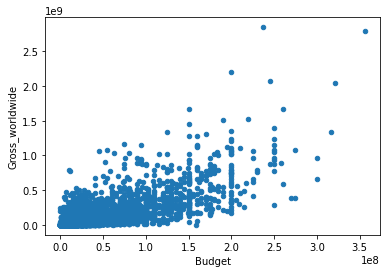

In [30]:
a.plot(kind="scatter", x ="Budget", y = "Gross_worldwide")
plt.show()